Plot Network Topology

In [18]:
from dotenv import load_dotenv
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import os
from sqlalchemy import create_engine
import networkx as nx
from create_random_network import load_network_from_database
from query_helpers import plot_cdf_with_shadow, get_last_simulation_output_id, get_timeseries_data

load_dotenv()

# Create SQLAlchemy engine
db_url = f"postgresql://{os.getenv('POSTGRES_DB_USER', 'root')}:{os.getenv('POSTGRES_DB_PASSWORD', 'skamasfrevrest')}@{os.getenv('POSTGRES_DB_HOST', '103.0.2.7')}:{os.getenv('POSTGRES_DB_PORT', '5433')}/{os.getenv('POSTGRES_DB_NAME', 'duilio')}"
engine = create_engine(db_url)
conn = engine.connect()

In [19]:
test_name = 'debug_random'

# Get the last simulation_output_id for the current test_name
simulation_output_id, simulation_parameters = get_last_simulation_output_id(test_name, conn)

if simulation_output_id:
    print(f"Last simulation_output_id for test_name '{test_name}': {simulation_output_id}")
    # Create conn_parameters dict for load_network_from_database
    conn_parameters = {
        "dbname": os.getenv("POSTGRES_DB_NAME", "duilio"),
        "user": os.getenv("POSTGRES_DB_USER", "root"),
        "password": os.getenv("POSTGRES_DB_PASSWORD", "skamasfrevrest"),
        "host": os.getenv("POSTGRES_DB_HOST", "103.0.2.7"),
        "port": int(os.getenv("POSTGRES_DB_PORT", "5433"))
    }
    pandapower_grid_id, net, graph = load_network_from_database(conn_parameters, simulation_parameters['network_id'])
else:
    print(f"No simulation found for test_name '{test_name}'")



Last simulation_output_id for test_name 'debug_random': 197
Loaded network 'medium_test_network' with 17 buses and 16 connections


/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(np.nan)
/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(np.nan)
/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('f

Plot the simulated network

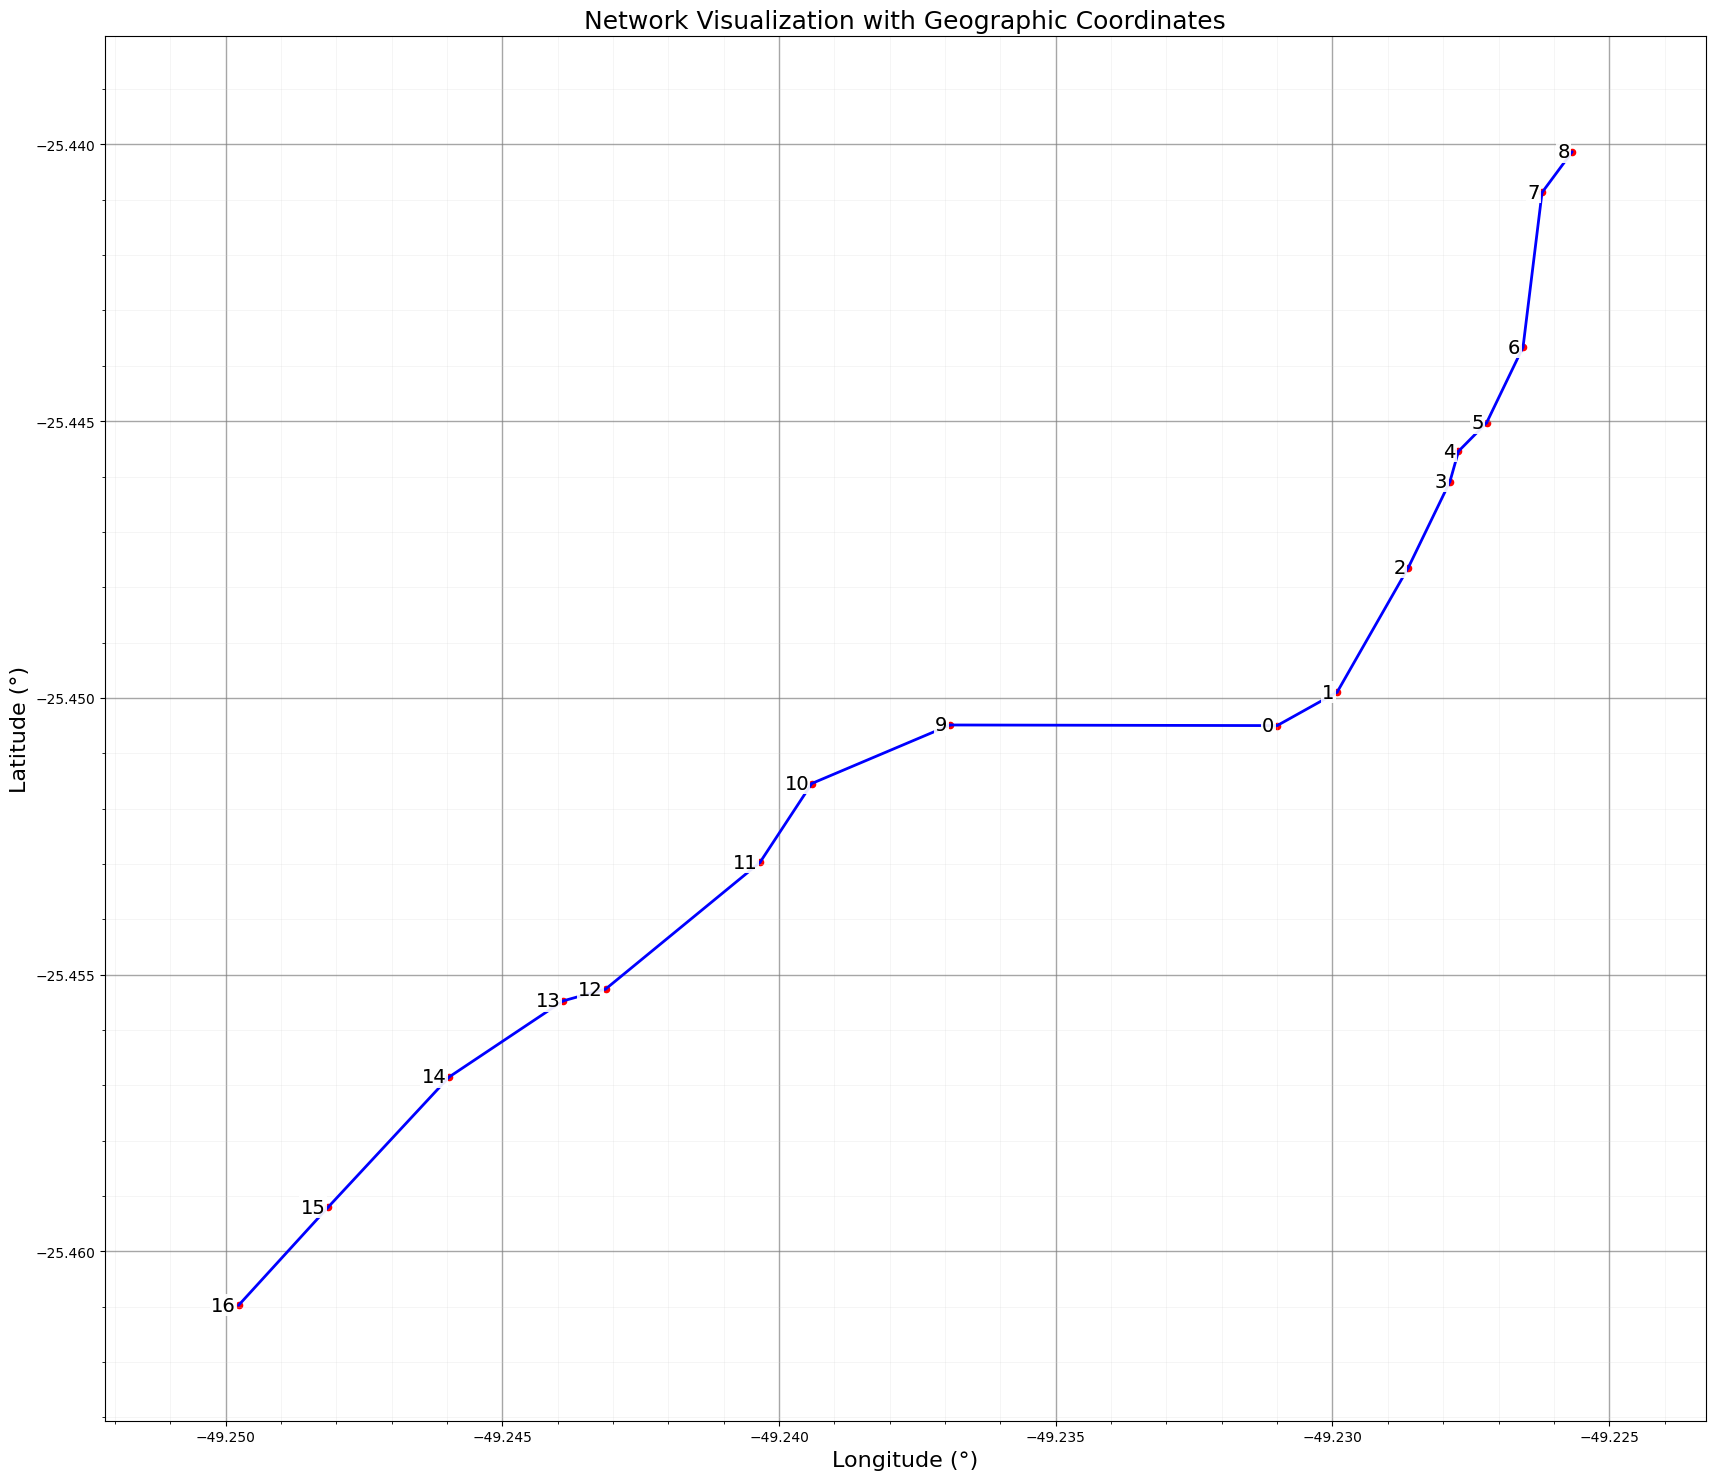

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas
from shapely.geometry import Point, LineString

# 1. Extract bus coordinates
bus_points = [Point(row['x'], row['y']) if not pd.isna(row['x']) and not pd.isna(row['y']) else None 
             for idx, row in net.bus_geodata.iterrows()]

# 2. Create GeoSeries
bus_geo_series = geopandas.GeoSeries(bus_points)

# 3. Create lines from graph edges
line_geometries = []
for u, v, _ in graph.edges(data=True):
    if u < len(bus_points) and v < len(bus_points) and bus_points[u] and bus_points[v]:
        line_geometries.append(LineString([bus_points[u], bus_points[v]]))
    else:
        print(f"Warning: Skipping line between bus {u} and {v}")

# 4. Create GeoDataFrame
line_geo_df = geopandas.GeoDataFrame({'geometry': line_geometries})

# 5. Create figure with large size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot network
line_geo_df.plot(ax=ax, color='blue', linewidth=2)
bus_geo_series.plot(ax=ax, color='red', markersize=20)

# Get bounds
valid_points = [p for p in bus_points if p]
if valid_points:
    min_x = min(p.x for p in valid_points)
    max_x = max(p.x for p in valid_points)
    min_y = min(p.y for p in valid_points)
    max_y = max(p.y for p in valid_points)
    
    # Add padding
    pad_x = (max_x - min_x) * 0.1
    pad_y = (max_y - min_y) * 0.1
    min_x -= pad_x
    max_x += pad_x
    min_y -= pad_y
    max_y += pad_y
    
    # Check if coordinates are likely lat/lon (small values around -180 to 180 for longitude and -90 to 90 for latitude)
    is_latlon = (min_x > -180 and max_x < 180 and min_y > -90 and max_y < 90)
    
    if is_latlon:
        # For lat/lon coordinates, use 0.001° grid (approx. 111m at equator) and 0.005° labels
        # 0.001° is roughly 111 meters at the equator
        minor_ticks_x = np.arange(np.floor(min_x/0.001)*0.001, np.ceil(max_x/0.001)*0.001, 0.001)
        minor_ticks_y = np.arange(np.floor(min_y/0.001)*0.001, np.ceil(max_y/0.001)*0.001, 0.001)
        major_ticks_x = np.arange(np.floor(min_x/0.005)*0.005, np.ceil(max_x/0.005)*0.005, 0.005)
        major_ticks_y = np.arange(np.floor(min_y/0.005)*0.005, np.ceil(max_y/0.005)*0.005, 0.005)
        
        # Set ticks and grid
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.set_xticks(minor_ticks_x, minor=True)
        ax.set_yticks(minor_ticks_y, minor=True)
        
        # Grid styling
        ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.7)
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add coordinate labels only for major ticks (with less frequent labels for readability)
        # Show fewer labels to avoid overcrowding
        # for i, x in enumerate(major_ticks_x):
        #     if i % 2 == 0:  # Only show every other label
        #         ax.text(x, min_y - pad_y*0.3, f'{x:.4f}°', 
        #                ha='center', va='top', fontsize=10, color='black')
        # for i, y in enumerate(major_ticks_y):
        #     if i % 2 == 0:  # Only show every other label
        #         ax.text(min_x - pad_x*0.3, y, f'{y:.4f}°', 
        #                ha='right', va='center', fontsize=10, color='black')
                       
        plot_title = "Network Visualization with Geographic Coordinates"
        x_label = "Longitude (°)"
        y_label = "Latitude (°)"
    else:
        # Assume meters format (original code)
        # Create 50m grid (minor) and 100m ticks (major)
        major_ticks = np.arange(np.floor(min_x/100)*100, np.ceil(max_x/100)*100, 100)
        minor_ticks = np.arange(np.floor(min_x/50)*50, np.ceil(max_x/50)*50, 50)
        
        # Set ticks and grid
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(minor_ticks, minor=True)
        
        # Grid styling - major (100m) is bolder
        ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.7)
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add coordinate labels only for major ticks
        for x in major_ticks:
            ax.text(x, min_y - pad_y*0.3, f'{x:.0f}m', 
                   ha='center', va='top', fontsize=12, color='black')
        for y in major_ticks:
            ax.text(min_x - pad_x*0.3, y, f'{y:.0f}m', 
                   ha='right', va='center', fontsize=12, color='black')
                   
        plot_title = "Network Visualization with 50m Grid (100m Labels)"
        x_label = "X Coordinate (m)"
        y_label = "Y Coordinate (m)"

# Annotate buses

# Set axis limits to only span the network area (with a small padding)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Make the plot narrower and shorter
fig.set_size_inches(17, 17)

for idx, point in enumerate(bus_geo_series):
    if point:
        ax.text(point.x - pad_x*0.02, point.y, str(idx),
               fontsize=14, color='black', ha='right', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
for idx, point in enumerate(bus_geo_series):
    if point:
        ax.text(point.x - pad_x*0.02, point.y, str(idx),
               fontsize=14, color='black', ha='right', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Set the plot title using ax.set_title instead of plt.title to avoid layout issues
ax.set_title(plot_title, fontsize=18)

# Remove extra whitespace around the plot by tightening the layout
plt.tight_layout()
plt.xlabel(x_label, fontsize=16)
plt.ylabel(y_label, fontsize=16)
#ax.set_aspect('equal')

# Save as PDF
plt.savefig('network_visualization_clean_grid.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

Plot network power

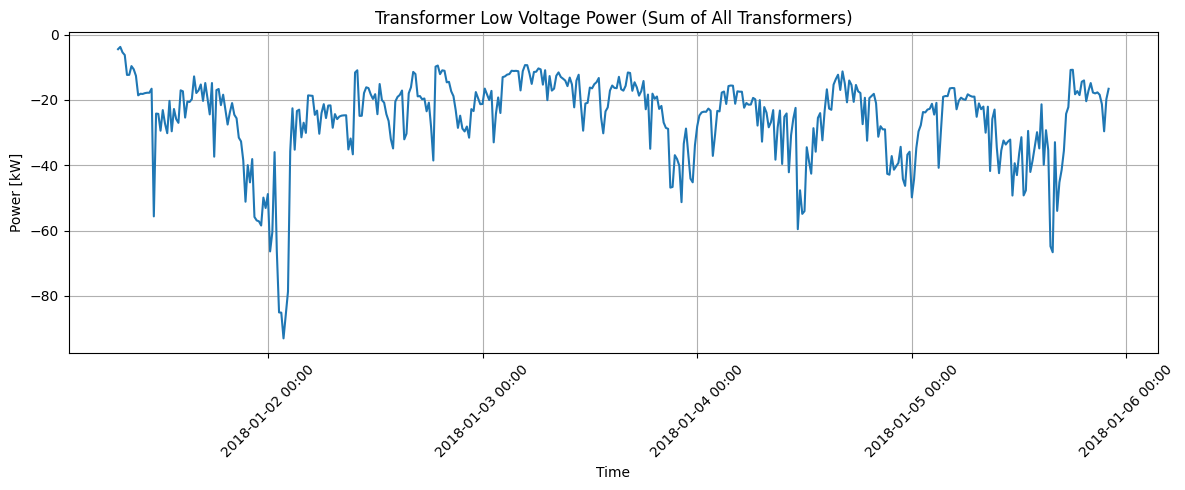

In [21]:
# Query transformer low voltage power time series for the last simulation
df_trafo_lv = get_timeseries_data(
    conn,
    simulation_output_id,
    element_type='transformer',
    output_name='P_%_lv[MW]'
)

if df_trafo_lv.empty:
    print("No transformer low voltage power data found for this simulation.")
else:
    df_trafo_lv['bucket'] = pd.to_datetime(df_trafo_lv['bucket'])
    plt.figure(figsize=(12, 5))
    plt.plot(df_trafo_lv['bucket'], df_trafo_lv['total_quantity'] * 1000)
    plt.title('Transformer Low Voltage Power (Sum of All Transformers)')
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Power [kW]')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Power Generation/Use

No data found for State of Charge


/tmp/ipykernel_3389274/2599303495.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


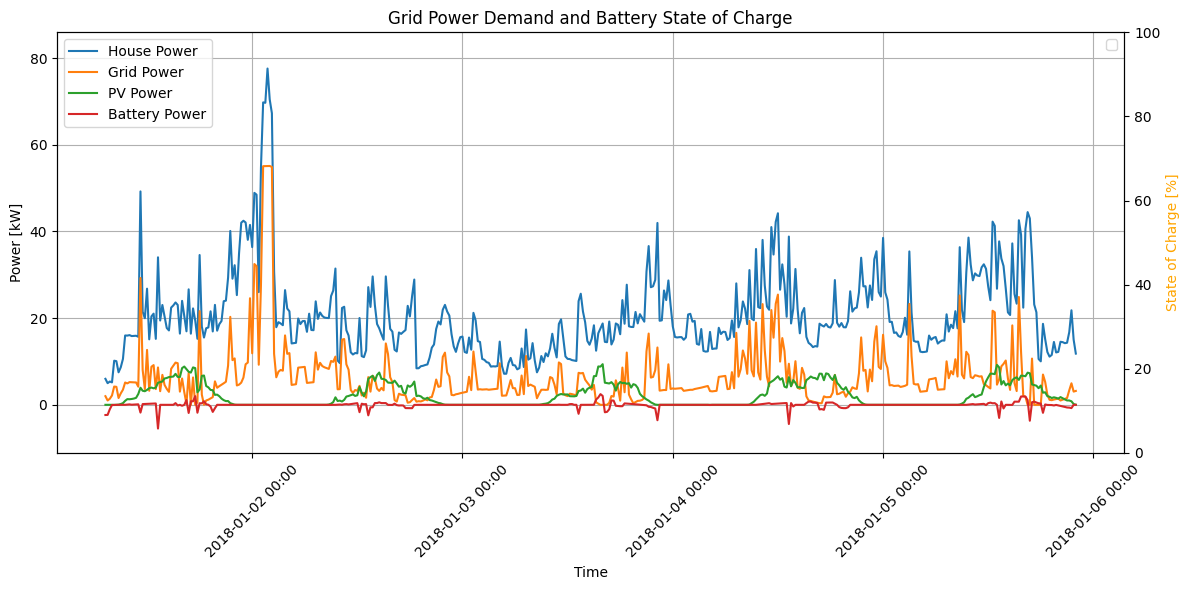

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for CSV export
csv_df = pd.DataFrame()
lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---
for idx, trafo in net.trafo.iterrows():    
    lv_buses.extend(list(nx.descendants(graph,trafo['lv_bus'])))

# Remove duplicates
lv_buses = list(set(lv_buses))  

energy_outputs = [
    ('Power[kW]', 'House Power', 1),
    ('P_%_load[MW]', 'Grid Power', 1000),    
    ('PVPowerGeneration[MW]', 'PV Power', 1000),
    ('BatteryPower[MW]', 'Battery Power', 1000),
]
# Create a second y-axis for SOC
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()


# Plot power data on the left y-axis
for output_name, label, multiplier in energy_outputs:
    # print(explain_get_timeseries_data(
    #     conn,
    #     simulation_output_id,
    #     output_name=output_name,
    #     element_idxs=lv_buses
    # ))

    df_energy = get_timeseries_data(
        conn,
        simulation_output_id,
        output_name=output_name,
        element_idxs=lv_buses
    )
    if not df_energy.empty:
        df_energy['bucket'] = pd.to_datetime(df_energy['bucket'])
        ax1.plot(df_energy['bucket'], df_energy['total_quantity'] * multiplier, label=label)
        # Append to CSV DataFrame
        csv_df_temp = df_energy.copy()
        csv_df_temp.rename(columns={'total_quantity': label.replace(" ", "_")}, inplace=True)
        if csv_df.empty:
            csv_df = csv_df_temp
        else:
            csv_df = pd.merge(csv_df, csv_df_temp, on='bucket', how='outer')
    else:
        print(f"No data found for {label}")

# Get the overall storage capacity
total_capacity = 0
for bus in lv_buses:
    if 'household_params' in graph.nodes[bus]:
        total_capacity += graph.nodes[bus]['household_params'].get('StorageCapacity_MWh', 0)


# print(explain_get_timeseries_data(
#                             conn,
#                             simulation_output_id,
#                             output_name='SOC[MWh]',
#                             element_idxs=lv_buses
#                             )
#      )

# Plot SOC on the right y-axis
df_soc = get_timeseries_data(
    conn,
    simulation_output_id,
    output_name='SOC[MWh]',
    element_idxs=lv_buses
)
if not df_soc.empty and total_capacity > 0:
    df_soc['bucket'] = pd.to_datetime(df_soc['bucket'])
    ax2.plot(df_soc['bucket'], 100*df_soc['total_quantity']/total_capacity, color='orange', label='State of Charge')
    # Append to CSV DataFrame
    csv_df_temp = df_soc.copy()
    csv_df_temp['total_quantity'] = 100*csv_df_temp['total_quantity']/total_capacity
    csv_df_temp.rename(columns={'total_quantity': 'State_of_Charge_%'}, inplace=True)
    if csv_df.empty:
        csv_df = csv_df_temp
    else:
        csv_df = pd.merge(csv_df, csv_df_temp, on='bucket', how='outer')
else:
    print("No data found for State of Charge")

# Configure axes
ax1.set_xlabel('Time')
ax1.set_ylabel('Power [kW]', color='black')
ax2.set_ylabel('State of Charge [%]', color='orange')
ax2.set_ylim(0, 100)
# Adjust SOC y-axis to show full range with some padding
soc_min = df_soc['total_quantity'].min()
soc_max = df_soc['total_quantity'].max()
soc_range = soc_max - soc_min
padding = soc_range * 0.1 if soc_range > 0 else 5
# Calculate power range for aligning zeros
power_values = []
for output_name, label, multiplier in energy_outputs:
    df_energy = get_timeseries_data(conn, simulation_output_id, output_name=output_name)
    if not df_energy.empty:
        power_values.extend((df_energy['total_quantity'] * multiplier).tolist())

if power_values:
    min_power = min(power_values)
    max_power = max(power_values)
    if max_power > min_power:
        rel_zero = (0 - min_power) / (max_power - min_power)
        ylim_min2 = 0 - rel_zero * 100
        ylim_max2 = 100 - rel_zero * 100
        ax1.set_ylim(min_power, max_power)
        ax2.set_ylim(ylim_min2, ylim_max2)
    else:
        ax1.set_ylim(min_power*1.05, max_power*1.05)
        ax2.set_ylim(0, 100)
else:
    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, 100)
# Set both axes to start from zero
#ax1.set_ylim(0, None)  # Power axis starts from zero
ax2.set_ylim(0, 100)   # SOC axis from 0 to 100%
# Format x-axis
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


ax1.grid(True)
plt.title('Grid Power Demand and Battery State of Charge')
plt.tight_layout()
plt.show()

if not csv_df.empty:
    csv_df.to_csv('power_and_soc_results.csv', index=False)




Check solar irradiation

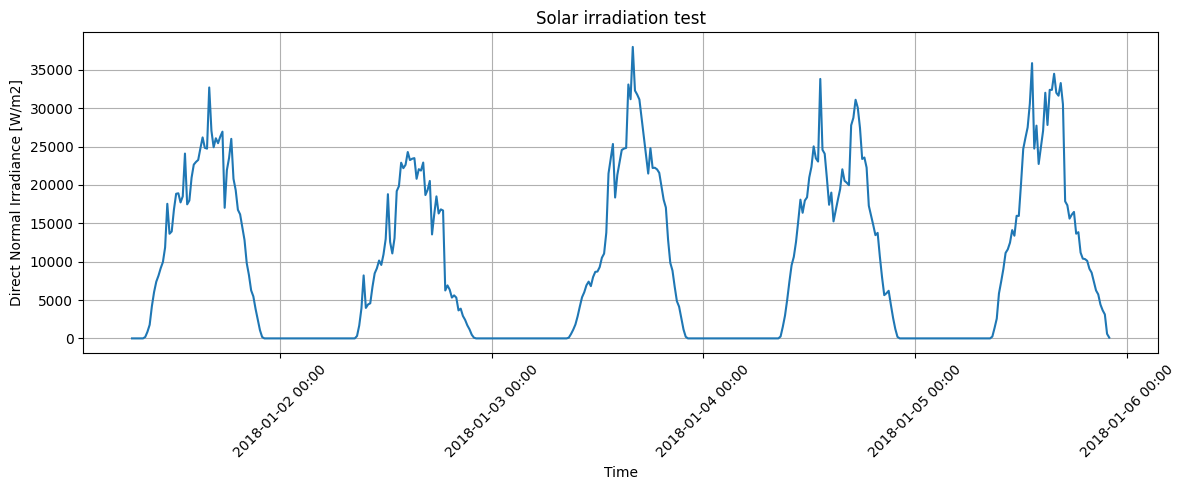

In [11]:
# Query transformer low voltage power time series for the last simulation
df_solar = get_timeseries_data(
    conn,
    simulation_output_id,
    element_type='solarirradiation',
    output_name='DNI[W/m2]'
)

if df_solar.empty:
    print("No solar data found for this simulation.")
else:
    df_solar['bucket'] = pd.to_datetime(df_solar['bucket'])
    plt.figure(figsize=(12, 5))
    plt.plot(df_solar['bucket'], df_solar['total_quantity'])
    plt.title('Solar irradiation test')
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Direct Normal Irradiance [W/m2]')
    plt.grid(True)
    plt.tight_layout()
    plt.show()





Tensão nas barras

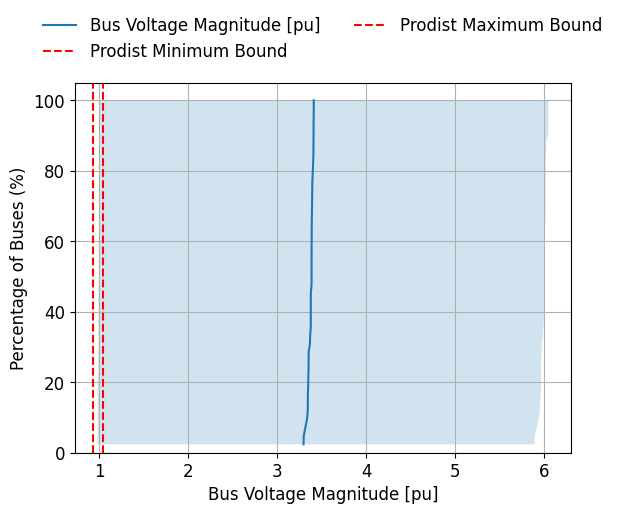

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---
for idx, trafo in net.trafo.iterrows():    
    lv_buses.extend(list(nx.descendants(graph,trafo['lv_bus'])))

# Remove duplicates
lv_buses = list(set(lv_buses))  

# --- Step 2: Query Vm_[pu] for each bus via get_timeseries_data ---
all_bus_data = {}

for bus in lv_buses:
    # each bus typically has Vm_a[pu], Vm_b[pu], Vm_c[pu]
    for phase in ["a", "b", "c"]:
        output_name = f"Vm_{phase}[pu]"
        df = get_timeseries_data(
            conn,
            simulation_output_id,
            element_type="bus",
            element_idxs=bus,
            output_name=output_name
        )

        if not df.empty:
            all_bus_data[f"Bus-{bus}-{output_name}"] = df["total_quantity"].values

# --- Step 3: Organize into DataFrame ---
voltage_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_bus_data.items()]))

# --- Step 4: Compute statistics ---
stats_df = pd.DataFrame({
    "Average": voltage_df.mean(),
    "Max": voltage_df.max(),
    "Min": voltage_df.min()
})

# Extract vectors from stats_df
average_vector = stats_df["Average"].values
max_vector = stats_df["Max"].values
min_vector = stats_df["Min"].values
# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Voltage Magnitude [pu]')

plt.xlabel('Bus Voltage Magnitude [pu]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Perda de potência ativa nas barras

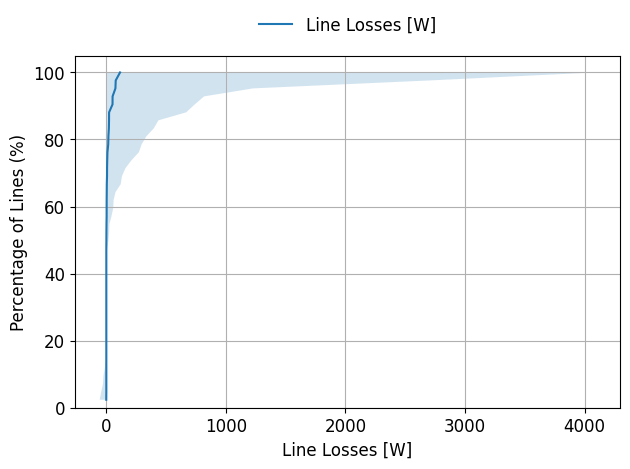

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---

all_line_data = {}

#we will start from each trafo lv_bus and traverse the graph to collect all lines that connect its descendents
to_visit = net.trafo['lv_bus'].values.tolist() 
while to_visit:
    current_bus = to_visit.pop()
    
    #get all lines from current_bus
    bus_lines = net.line[net.line['from_bus']==current_bus]

    #iterate over lines, getting its losses
    for idx, line in bus_lines.iterrows():
        #the line destination must be visited too
        to_visit.append(line['to_bus'])
    
        #get all losses for the phases of this line
        for phase in ["a", "b", "c"]:
            output_name = f"Pl_{phase}[MW]"
            df = get_timeseries_data(
                conn,
                simulation_output_id,
                element_type="line",
                element_idxs=idx,
                output_name=output_name
            )

            if not df.empty:
                all_line_data[f"Line-{idx}-{output_name}"] = df["total_quantity"].values*1e6  # Convert MW to W

# --- Step 3: Organize into DataFrame ---
line_loss_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_line_data.items()]))

# --- Step 4: Compute statistics ---
stats_df = pd.DataFrame({
    "Average": line_loss_df.mean(),
    "Max": line_loss_df.max(),
    "Min": line_loss_df.min()
})

average_vector = stats_df["Average"].values
max_vector = stats_df["Max"].values
min_vector = stats_df["Min"].values

# --- Step 5: Plot ---
plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Losses [W]')

plt.xlabel('Line Losses [W]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, None)
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.tight_layout()
plt.show()


Corrente de Neutro

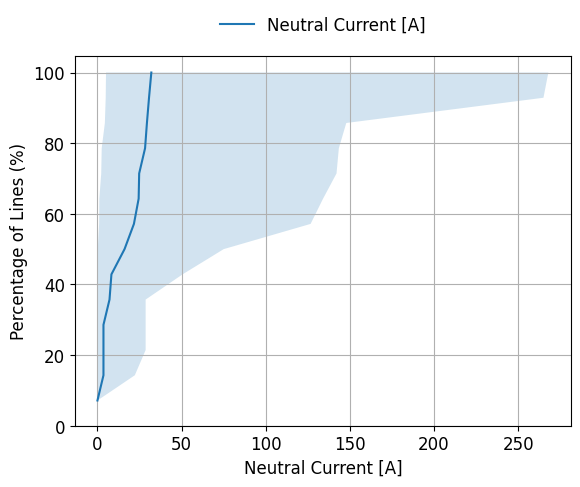

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---

all_line_data = {}

#we will start from each trafo lv_bus and traverse the graph to collect all lines that connect its descendents
to_visit = net.trafo['lv_bus'].values.tolist() 
while to_visit:
    current_bus = to_visit.pop()
    
    #get all lines from current_bus
    bus_lines = net.line[net.line['from_bus']==current_bus]

    #iterate over lines, getting its neutral current
    for idx, line in bus_lines.iterrows():
        #the line destination must be visited too
        to_visit.append(line['to_bus'])
    
        #get all neutral current for the phases of this line
        
        output_name = f"I_n_from[kA]"
        df = get_timeseries_data(
            conn,
            simulation_output_id,
            element_type="line",
            element_idxs=idx,
            output_name=output_name
        )

        if not df.empty:
            all_line_data[f"Line-{idx}-{output_name}"] = df["total_quantity"].values*1e3  # Convert kA to A


# --- Step 3: Organize into DataFrame ---
neutral_current_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_line_data.items()]))

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': neutral_current_df.mean(),
    'Max': neutral_current_df.max(),
    'Min': neutral_current_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Neutral Current [A]')

plt.xlabel('Neutral Current [A]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Line Loading

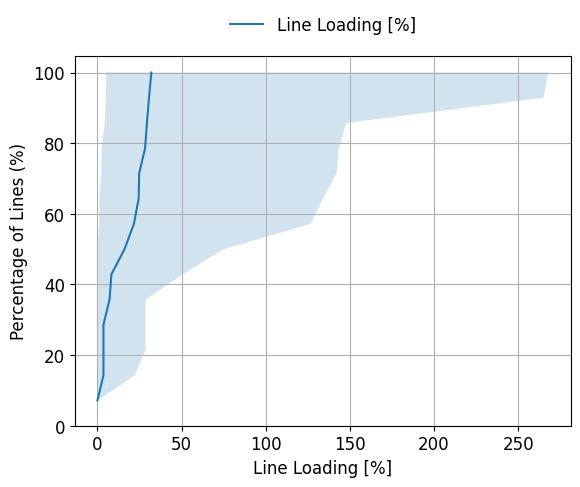

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---

all_line_data = {}

#we will start from each trafo lv_bus and traverse the graph to collect all lines that connect its descendents
to_visit = net.trafo['lv_bus'].values.tolist() 
while to_visit:
    current_bus = to_visit.pop()
    
    #get all lines from current_bus
    bus_lines = net.line[net.line['from_bus']==current_bus]

    #iterate over lines, getting its neutral current
    for idx, line in bus_lines.iterrows():
        #the line destination must be visited too
        to_visit.append(line['to_bus'])
    
        #get all neutral current for the phases of this line
        
        output_name = f"Loading[%]"
        df = get_timeseries_data(
            conn,
            simulation_output_id,
            element_type="line",
            element_idxs=idx,
            output_name=output_name
        )

        if not df.empty:
            all_line_data[f"Line-{idx}-{output_name}"] = df["total_quantity"].values*1e3  # Convert kA to A


# --- Step 3: Organize into DataFrame ---
Loading_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_line_data.items()]))


# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Loading [%]')

plt.xlabel('Line Loading [%]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Desbalanceamento de Barramentos

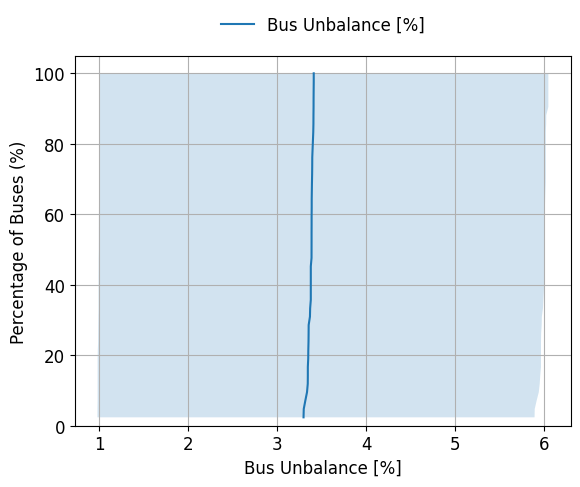

In [16]:

import pandas as pd
import matplotlib.pyplot as plt

lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---
for idx, trafo in net.trafo.iterrows():    
    lv_buses.extend(list(nx.descendants(graph,trafo['lv_bus'])))

# Remove duplicates
lv_buses = list(set(lv_buses))  

# --- Step 2: Query Unbalance[%] for each bus via get_timeseries_data ---
all_bus_data = {}

for bus in lv_buses:
    # each bus typically has Vm_a[pu], Vm_b[pu], Vm_c[pu]
    
    output_name = f"Unbalance[%]"
    df = get_timeseries_data(
        conn,
        simulation_output_id,
        element_type="bus",
        element_idxs=bus,
        output_name=output_name
    )

    if not df.empty:
        all_bus_data[f"Bus-{bus}-{output_name}"] = df["total_quantity"].values

# --- Step 3: Organize into DataFrame ---
unbalance_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_bus_data.items()]))

# --- Step 4: Compute statistics ---
stats_df = pd.DataFrame({
    "Average": voltage_df.mean(),
    "Max": voltage_df.max(),
    "Min": voltage_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Unbalance [%]')

plt.xlabel('Bus Unbalance [%]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Power Flux Inversion at LV Transformers

ValueError: zero-size array to reduction operation maximum which has no identity

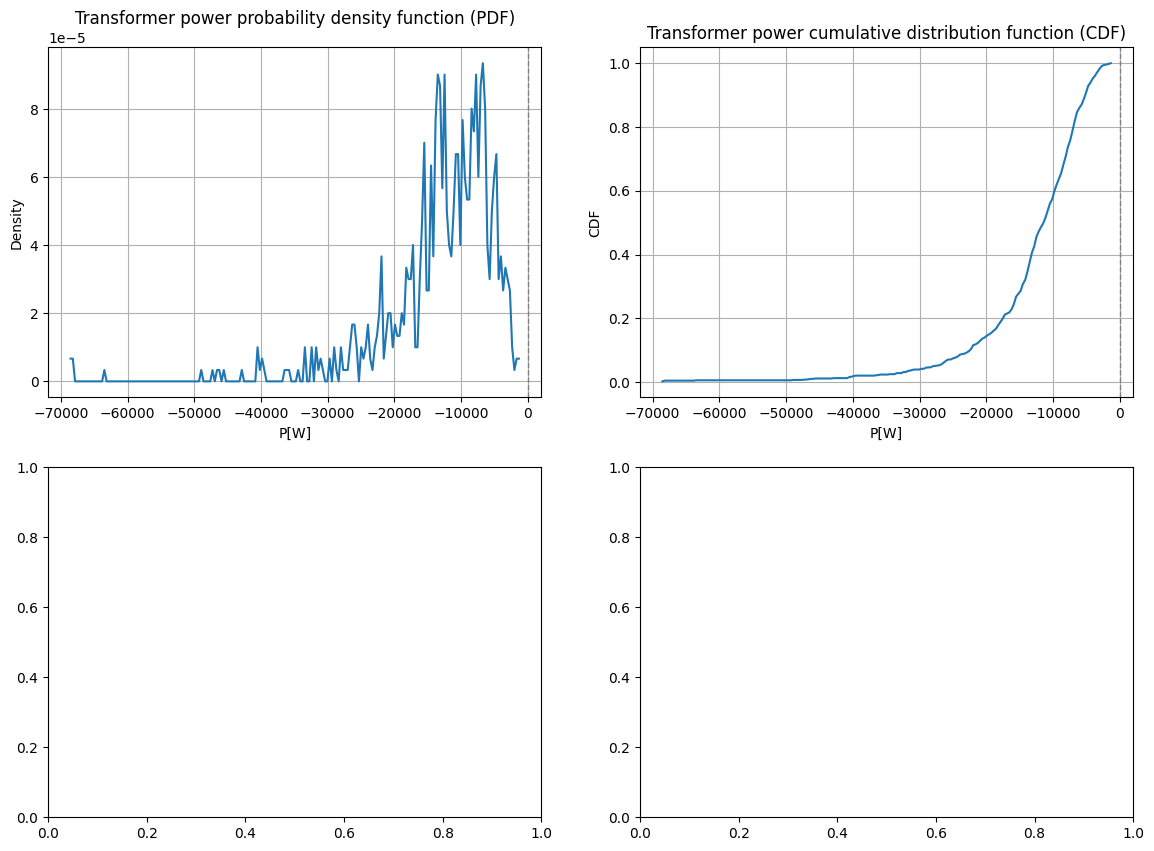

In [17]:
import numpy as np
import matplotlib.pyplot as plt

lv_buses = []
trafos = net.trafo.index.to_list()
ext_grids = net.ext_grid.index.to_list()
# --- Step 1: Collect all bus descendants from trafos ---
for idx, trafo in net.trafo.iterrows():    
    lv_buses.extend(list(nx.descendants(graph,trafo['lv_bus'])))

# Remove duplicates
lv_buses = list(set(lv_buses))  

# Query transformer low voltage power for each transformer separately
trafo_power_dfs = {}
for trafo_idx in trafos:
    output_name = 'P_%_lv[MW]'
    df = get_timeseries_data(
        conn,
        simulation_output_id,
        element_type="transformer",
        element_idxs=trafo_idx,
        output_name=output_name
    )
    if not df.empty:
        df['bucket'] = pd.to_datetime(df['bucket'])
        trafo_power_dfs[trafo_idx] = df

ext_grid_power_dfs = {}
for ext_grid_idx in ext_grids:
    output_name = 'P_%[MW]'
    df = get_timeseries_data(
        conn,
        simulation_output_id,
        element_type="externalgrid",
        element_idxs=ext_grid_idx,
        output_name=output_name
    )    
    if not df.empty:
        df['bucket'] = pd.to_datetime(df['bucket'])
        ext_grid_power_dfs[ext_grid_idx] = df

# ----------------------------------------------
# 1. Collect all transformer powers individually
# ----------------------------------------------
all_p_list = []

for trafo_idx, df in trafo_power_dfs.items():
    # Convert MW -> W 
    p = df['total_quantity'] * 1e6    
    p = p.dropna()
    all_p_list.append(p)

# Concatenate all transformer x hours series
all_p = pd.concat(all_p_list)


# ------------------------------------------------------------
# Data 
# ------------------------------------------------------------
all_p = np.array(all_p)   # ensure numpy array

# ------------------------------------------------------------
# Detect inversion start (first positive value)
# ------------------------------------------------------------
positive_values = all_p[all_p > 0]

if len(positive_values) > 0:
    inv_start = np.min(positive_values)
else:
    inv_start = None   # no inversion

# ------------------------------------------------------------
# Full-range bins
# ------------------------------------------------------------
bins_full = 200
hist_full, edges_full = np.histogram(all_p, bins=bins_full, density=True)
cdf_full = np.cumsum(hist_full) * np.diff(edges_full)

# ------------------------------------------------------------
# Zoom bins (positive region)
# ------------------------------------------------------------
bins_zoom = 400
hist_zoom, edges_zoom = np.histogram(all_p, bins=bins_zoom, density=True)
hist_zoom_cdf, edges_zoom_cdf = np.histogram(all_p, bins=bins_zoom*10, density=True)
cdf_zoom = np.cumsum(hist_zoom_cdf) * np.diff(edges_zoom_cdf)

# ------------------------------------------------------------
# Plotting
# ------------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# ============================================
# 1. PDF — Full Range
# ============================================
axs[0, 0].plot(edges_full[:-1], hist_full)
axs[0, 0].set_title("Transformer power probability density function (PDF)")
axs[0, 0].set_xlabel("P[W]")
axs[0, 0].set_ylabel("Density")
axs[0, 0].grid(True)

# Add P = 0 line
axs[0, 0].axvline(0, color='gray', linestyle='--', linewidth=1)

# Add inversion start line
if inv_start is not None:
    axs[0, 0].axvline(inv_start, color='red', linestyle='--', linewidth=1)

# ============================================
# 2. CDF — Full Range
# ============================================
axs[0, 1].plot(edges_full[:-1], cdf_full)
axs[0, 1].set_title("Transformer power cumulative distribution function (CDF)")
axs[0, 1].set_xlabel("P[W]")
axs[0, 1].set_ylabel("CDF")
axs[0, 1].grid(True)

# Add markers
axs[0, 1].axvline(0, color='gray', linestyle='--', linewidth=1)
if inv_start is not None:
    axs[0, 1].axvline(inv_start, color='red', linestyle='--', linewidth=1)

# ============================================
# 3. PDF — Zoom on Positive Region
# ============================================
zoom_max = np.max(all_p) 
y_max = np.max(hist_zoom[(edges_zoom[:-1] >= 0) & (edges_zoom[:-1] <= zoom_max)])

axs[1, 0].plot(edges_zoom[:-1], hist_zoom)
axs[1, 0].set_title("Transformer power probability density function (PDF) for inversion region")
axs[1, 0].set_xlabel("P[W]")
axs[1, 0].set_ylabel("Density")
axs[1, 0].set_xlim(0, zoom_max)
axs[1, 0].set_ylim(0, y_max)
axs[1, 0].grid(True)

# Markers in zoom
axs[1, 0].axvline(0, color='gray', linestyle='--', linewidth=1)
if inv_start is not None:
    axs[1, 0].axvline(inv_start, color='red', linestyle='--', linewidth=1)

# ============================================
# 4. CDF — Zoom on Positive Region
# ============================================
axs[1, 1].plot(edges_zoom_cdf[:-1], cdf_zoom)
axs[1, 1].set_title("Transformer power cumulative distribution function (CDF) for inversion region")
axs[1, 1].set_xlabel("P (MW)")
axs[1, 1].set_ylabel("CDF")
axs[1, 1].set_xlim(0, zoom_max)


# Adjust y-axis to visible zone
mask = (edges_zoom_cdf[:-1] >= 0) & (edges_zoom_cdf[:-1] <= zoom_max)
axs[1, 1].set_ylim(np.min(cdf_zoom[mask]), 1)
axs[1, 1].grid(True)

# Markers
axs[1, 1].axvline(0, color='gray', linestyle='--', linewidth=1)
if inv_start is not None:
    axs[1, 1].axvline(inv_start, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()





Total Power

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.13/site-packages/sqlalchemy/pool/base.py", line 985, in _finalize_fairy
    fairy._reset(
    ~~~~~~~~~~~~^
        pool,
        ^^^^^
    ...<2 lines>...
        asyncio_safe=can_manipulate_connection,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/usr/local/lib/python3.13/site-packages/sqlalchemy/pool/base.py", line 1433, in _reset
    pool._dialect.do_rollback(self)
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/usr/local/lib/python3.13/site-packages/sqlalchemy/engine/default.py", line 711, in do_rollback
    dbapi_connection.rollback()
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



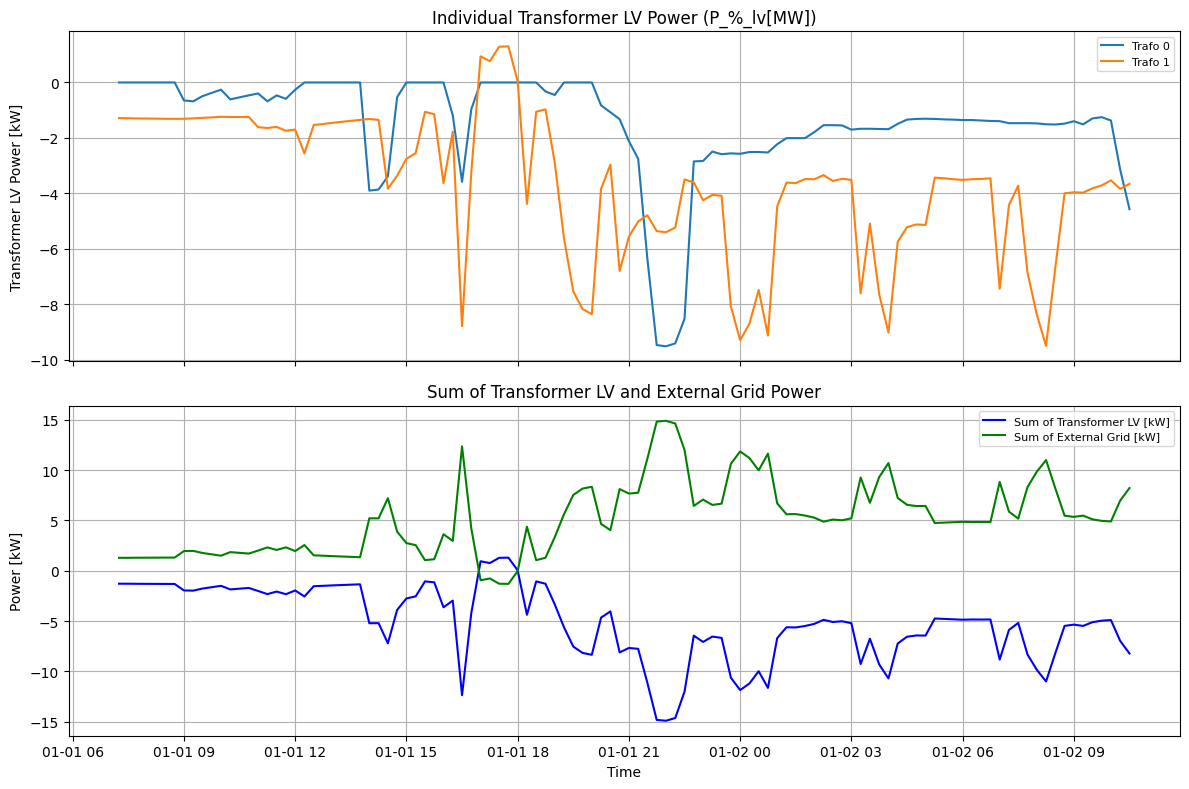

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

lv_buses = []
trafos = net.trafo.index.to_list()
ext_grids = net.ext_grid.index.to_list()
# --- Step 1: Collect all bus descendants from trafos ---
for idx, trafo in net.trafo.iterrows():    
    lv_buses.extend(list(nx.descendants(graph,trafo['lv_bus'])))

# Remove duplicates
lv_buses = list(set(lv_buses))  



# Query transformer low voltage power for each transformer separately
trafo_power_dfs = {}
for trafo_idx in trafos:
    output_name = 'P_%_lv[MW]'
    df = get_timeseries_data(
        conn,
        simulation_output_id,
        element_type="transformer",
        element_idxs=trafo_idx,
        output_name=output_name
    )
    if not df.empty:
        df['bucket'] = pd.to_datetime(df['bucket'])
        trafo_power_dfs[trafo_idx] = df


ext_grid_power_dfs = {}
for ext_grid_idx in ext_grids:
    output_name = 'P_%[MW]'
    df = get_timeseries_data(
        conn,
        simulation_output_id,
        element_type="externalgrid",
        element_idxs=ext_grid_idx,
        output_name=output_name
    )
    
    if not df.empty:
        df['bucket'] = pd.to_datetime(df['bucket'])
        ext_grid_power_dfs[ext_grid_idx] = df




# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Prepare and plot transformer LV power (each trafo) and sums with external grid

# First subplot: plot each transformer LV power in kW
for trafo_idx, df in trafo_power_dfs.items():
    axes[0].plot(df['bucket'], df['total_quantity'] * 1000, label=f'Trafo {trafo_idx}')
axes[0].set_ylabel('Transformer LV Power [kW]')
axes[0].set_title('Individual Transformer LV Power (P_%_lv[MW])')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(True)

# Build summed series aligned on bucket timestamps
# Sum of transformer LV power
trafo_sum_series = None
if trafo_power_dfs:
    trafo_sum_series = pd.concat(
        [df.set_index('bucket')['total_quantity'] for df in trafo_power_dfs.values()],
        axis=1
    ).sum(axis=1)

# Sum of external grid power
ext_grid_sum_series = None
if ext_grid_power_dfs:
    ext_grid_sum_series = pd.concat(
        [df.set_index('bucket')['total_quantity'] for df in ext_grid_power_dfs.values()],
        axis=1
    ).sum(axis=1)

# Second subplot: plot sums (convert MW to kW)
if trafo_sum_series is not None:
    axes[1].plot(trafo_sum_series.index, trafo_sum_series * 1000, label='Sum of Transformer LV [kW]', color='blue')
if ext_grid_sum_series is not None:
    axes[1].plot(ext_grid_sum_series.index, ext_grid_sum_series * 1000, label='Sum of External Grid [kW]', color='green')

axes[1].set_ylabel('Power [kW]')
axes[1].set_title('Sum of Transformer LV and External Grid Power')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True)

# Finalize plot
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Test power consumption data

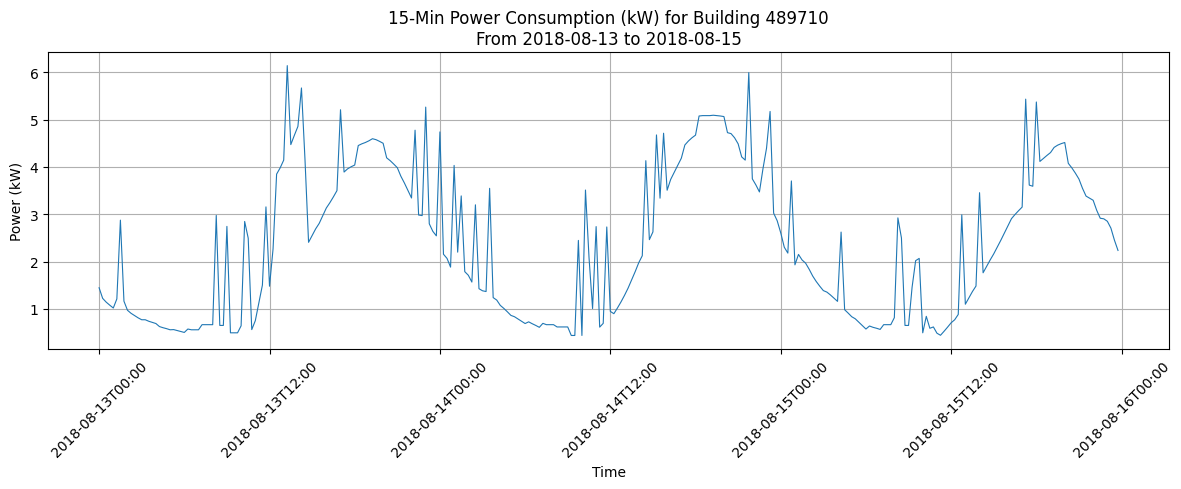

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import timedelta
import matplotlib.dates as mdates

def plot_random_power_15min(bldg_id: int, num_days: int):
    # Connection config
    db_url = f"postgresql://{os.getenv('POSTGRES_DB_USER', 'root')}:{os.getenv('POSTGRES_DB_PASSWORD', 'skamasfrevrest')}@{os.getenv('POSTGRES_DB_HOST', '103.0.2.7')}:{os.getenv('POSTGRES_DB_PORT', '5433')}/{os.getenv('POSTGRES_DB_NAME', 'duilio')}"
    engine = create_engine(db_url)
    conn = engine.connect()

    # Step 1: Get available daily buckets using TimescaleDB's time_bucket
    query = text("""
        SELECT DISTINCT time_bucket('1 day', sample_time) AS day
        FROM building_power.building_power
        WHERE bldg_id = :bldg_id
        ORDER BY day
    """)
    days = [row[0] for row in conn.execute(query, {"bldg_id": bldg_id}).fetchall()]
    
    if len(days) < num_days:
        print(f"Not enough days available (found {len(days)}, need {num_days}).")
        conn.close()
        return

    # Step 2: Pick a random start day
    start_idx = random.randint(0, len(days) - num_days)
    start_day = days[start_idx]
    end_day = start_day + timedelta(days=num_days)

    # Step 3: Fetch 15-min data for that period
    query = text("""
        SELECT sample_time, electricity_total_energy_consumption / 0.25 AS power_kw
        FROM building_power.building_power
        WHERE bldg_id = :bldg_id
          AND sample_time >= :start_day
          AND sample_time < :end_day
          AND electricity_total_energy_consumption IS NOT NULL
        ORDER BY sample_time
    """)
    rows = conn.execute(query, {"bldg_id": bldg_id, "start_day": start_day, "end_day": end_day}).fetchall()
    conn.close()

    if not rows:
        print("No data found in selected time range.")
        return

    # Step 4: Plot
    df = pd.DataFrame(rows, columns=["sample_time", "power_kw"])
    df["sample_time"] = pd.to_datetime(df["sample_time"])

    plt.figure(figsize=(12, 5))
    plt.plot(df["sample_time"], df["power_kw"], linewidth=0.8)
    plt.title(f"15-Min Power Consumption (kW) for Building {bldg_id}\nFrom {start_day.date()} to {(end_day - timedelta(days=1)).date()}")
    plt.xlabel("Time")
    plt.ylabel("Power (kW)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%H:%M'))
    plt.tight_layout()
    plt.show()

# Example usage:
plot_random_power_15min(bldg_id=489710, num_days=3)

CDF das potências do banco de dados


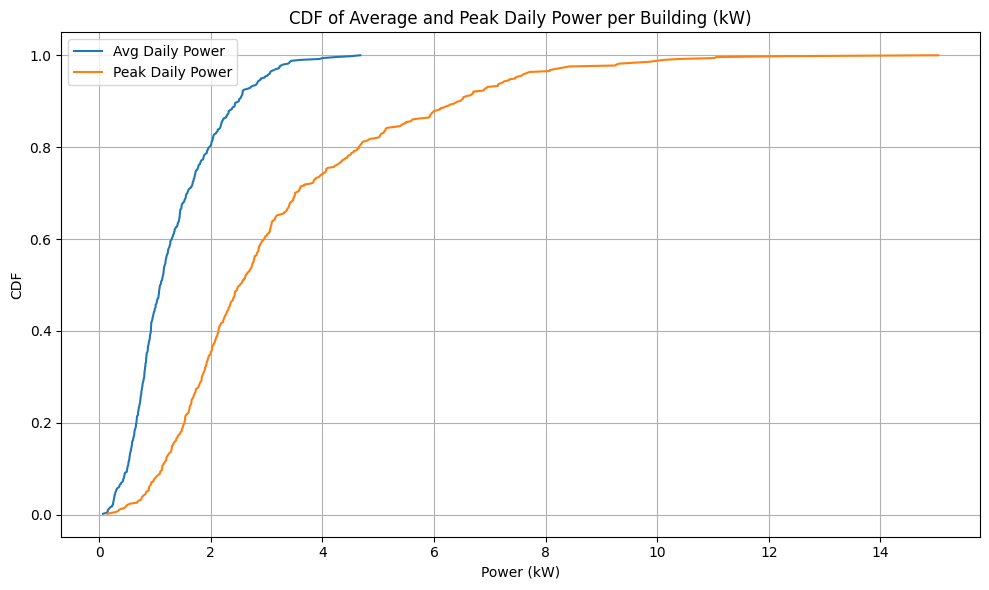

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_cdf_avg_power():
    # Connect to the database
    db_url = f"postgresql://{os.getenv('POSTGRES_DB_USER', 'root')}:{os.getenv('POSTGRES_DB_PASSWORD', 'skamasfrevrest')}@{os.getenv('POSTGRES_DB_HOST', '103.0.2.7')}:{os.getenv('POSTGRES_DB_PORT', '5433')}/{os.getenv('POSTGRES_DB_NAME', 'duilio')}"
    engine = create_engine(db_url)
    conn = engine.connect()

    # Step 1: Query average daily energy per building
    query = text("""
        SELECT 
        bldg_id,
        AVG(electricity_total_energy_consumption) / 24.0 AS avg_daily_power_kw,
        MAX(electricity_total_energy_consumption) / 24.0 AS peak_daily_power_kw
        FROM building_power.daily_energy
        WHERE electricity_total_energy_consumption IS NOT NULL
        GROUP BY bldg_id;
    """)
    rows = conn.execute(query).fetchall()
    conn.close()

    if not rows:
        print("No data returned.")
        return

    # Step 2: Convert to DataFrame
    df = pd.DataFrame(rows, columns=["bldg_id", "avg_daily_power_kw", "peak_daily_power_kw"])

    # Step 3: Prepare data for CDF
    sorted_avg = np.sort(df["avg_daily_power_kw"])
    cdf_avg = np.arange(1, len(sorted_avg) + 1) / len(sorted_avg)

    sorted_peak = np.sort(df["peak_daily_power_kw"].dropna())
    cdf_peak = np.arange(1, len(sorted_peak) + 1) / len(sorted_peak)

    # Step 2: Plot both CDFs
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_avg, cdf_avg, label="Avg Daily Power")
    plt.plot(sorted_peak, cdf_peak, label="Peak Daily Power")
    plt.title("CDF of Average and Peak Daily Power per Building (kW)")
    plt.xlabel("Power (kW)")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_cdf_avg_power()

Average total power consumption: 0.59 kW
Peak total power consumption: 2.02 kW
Minimum total power consumption: 0.10 kW
Load factor: 0.29
Average phase imbalance: 149.63%


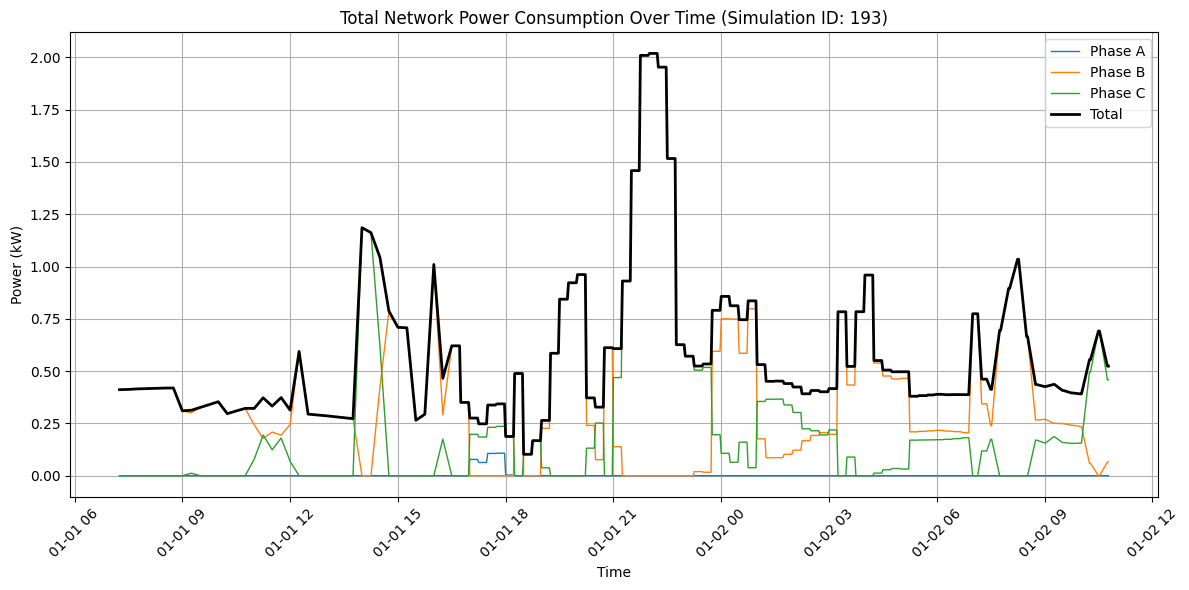

/tmp/ipykernel_3327015/1561322130.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Phase A', 'Phase B', 'Phase C'])


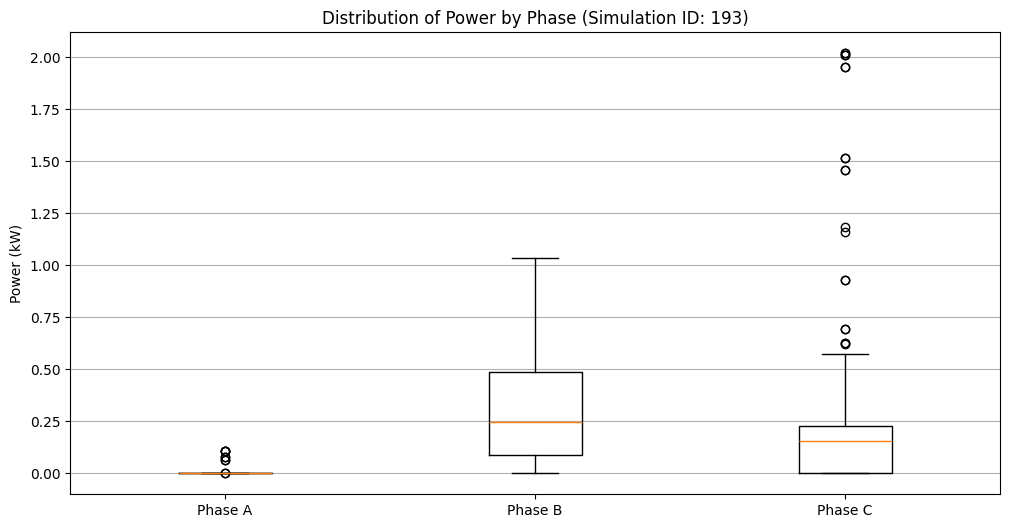

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_total_network_power(simulation_output_id):
    """
    Plot the total power consumption of the network based on P_a[MW], P_b[MW], and P_c[MW]
    of all low voltage buses connected to transformers.
    
    Args:
        simulation_output_id (int): The ID of the simulation output to analyze
    """
    # Connect to the database
    db_url = f"postgresql://{os.getenv('POSTGRES_DB_USER', 'root')}:{os.getenv('POSTGRES_DB_PASSWORD', 'skamasfrevrest')}@{os.getenv('POSTGRES_DB_HOST', '103.0.2.7')}:{os.getenv('POSTGRES_DB_PORT', '5433')}/{os.getenv('POSTGRES_DB_NAME', 'duilio')}"
    engine = create_engine(db_url)
    conn = engine.connect()
    
    # Direct SQL query to get time series data for P_a[MW], P_b[MW], and P_c[MW] for all buses
    query = text("""
        WITH bus_power_vars AS (
            SELECT v.variable_id, v.variable_name,
                   CASE 
                       WHEN v.variable_name LIKE '%P_a[MW]' THEN 'a'
                       WHEN v.variable_name LIKE '%P_b[MW]' THEN 'b'
                       WHEN v.variable_name LIKE '%P_c[MW]' THEN 'c'
                       ELSE NULL
                   END AS phase
            FROM building_power.variable v
            WHERE v.simulation_output_id = :simulation_output_id
              AND v.variable_name LIKE 'Pandapower-0.Bus-%'
              AND v.variable_name LIKE '%%[MW]'
              AND (v.variable_name LIKE '%%P_a[MW]' OR 
                   v.variable_name LIKE '%%P_b[MW]' OR 
                   v.variable_name LIKE '%%P_c[MW]')
        ),
        timeseries_data AS (
            SELECT 
                ts,
                bpv.phase,
                SUM(ots.quantity) AS total_power_mw
            FROM building_power.output_timeseries ots
            JOIN bus_power_vars bpv ON ots.variable_id = bpv.variable_id
            GROUP BY ts, bpv.phase
            ORDER BY ts, bpv.phase
        )
        SELECT 
            ts,
            MAX(CASE WHEN phase = 'a' THEN total_power_mw ELSE 0 END) AS phase_a_mw,
            MAX(CASE WHEN phase = 'b' THEN total_power_mw ELSE 0 END) AS phase_b_mw,
            MAX(CASE WHEN phase = 'c' THEN total_power_mw ELSE 0 END) AS phase_c_mw
        FROM timeseries_data
        GROUP BY ts
        ORDER BY ts
    """)
    
    rows = conn.execute(query, {"simulation_output_id": simulation_output_id}).fetchall()
    
    if not rows:
        print(f"No time series data found for simulation_output_id {simulation_output_id}")
        conn.close()
        return
    
    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=['ts', 'phase_a_mw', 'phase_b_mw', 'phase_c_mw'])
    df['ts'] = pd.to_datetime(df['ts'])
    
    # Calculate total power across all phases
    df['total_mw'] = df['phase_a_mw'] + df['phase_b_mw'] + df['phase_c_mw']
    
    # Convert to kW for better readability
    df_kw = df.copy()
    for col in ['phase_a_mw', 'phase_b_mw', 'phase_c_mw', 'total_mw']:
        df_kw[col] = df[col] * 1000  # MW to kW
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    
    # Plot power by phase
    plt.plot(df_kw['ts'], df_kw['phase_a_mw'], label='Phase A', linewidth=1)
    plt.plot(df_kw['ts'], df_kw['phase_b_mw'], label='Phase B', linewidth=1)
    plt.plot(df_kw['ts'], df_kw['phase_c_mw'], label='Phase C', linewidth=1)
    
    # Plot total power (thicker line)
    plt.plot(df_kw['ts'], df_kw['total_mw'], label='Total', linewidth=2, color='black')
    
    plt.title(f'Total Network Power Consumption Over Time (Simulation ID: {simulation_output_id})')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Print some stats
    print(f"Average total power consumption: {df_kw['total_mw'].mean():.2f} kW")
    print(f"Peak total power consumption: {df_kw['total_mw'].max():.2f} kW")
    print(f"Minimum total power consumption: {df_kw['total_mw'].min():.2f} kW")
    
    # Show load factor
    load_factor = df_kw['total_mw'].mean() / df_kw['total_mw'].max() if df_kw['total_mw'].max() > 0 else 0
    print(f"Load factor: {load_factor:.2f}")
    
    # Calculate and show power imbalance between phases
    phase_columns = ['phase_a_mw', 'phase_b_mw', 'phase_c_mw']
    avg_phase_power = df_kw[phase_columns].mean().mean()
    phase_imbalance = df_kw[phase_columns].std(axis=1).mean() / avg_phase_power if avg_phase_power > 0 else 0
    print(f"Average phase imbalance: {phase_imbalance:.2%}")
    
    plt.show()
    
    # Create a second plot showing the distribution of power across phases
    plt.figure(figsize=(12, 6))
    
    # Create box plots for each phase
    box_data = [df_kw['phase_a_mw'], df_kw['phase_b_mw'], df_kw['phase_c_mw']]
    plt.boxplot(box_data, labels=['Phase A', 'Phase B', 'Phase C'])
    plt.title(f'Distribution of Power by Phase (Simulation ID: {simulation_output_id})')
    plt.ylabel('Power (kW)')
    plt.grid(True, axis='y')
    
    plt.show()
    
    conn.close()
    return df_kw

# Example usage with the current simulation_output_id
if simulation_output_id:
    power_data = plot_total_network_power(simulation_output_id)
else:
    print("No simulation_output_id available. Please run the previous cell to get a simulation_output_id.")

Plot simulation total power

In [ ]:



# This query can be copied directly to a SQL tool if needed
sql_query = """
WITH bus_power_vars AS (
    SELECT v.variable_id, v.variable_name,
           CASE 
               WHEN v.variable_name LIKE '%P_a[MW]' THEN 'a'
               WHEN v.variable_name LIKE '%P_b[MW]' THEN 'b'
               WHEN v.variable_name LIKE '%P_c[MW]' THEN 'c'
               ELSE NULL
           END AS phase
    FROM building_power.variable v
    WHERE v.simulation_output_id = {simulation_id}
      AND v.variable_name LIKE 'Pandapower-0.Bus-%'
      AND v.variable_name LIKE '%%[MW]'
      AND (v.variable_name LIKE '%%P_a[MW]' OR 
           v.variable_name LIKE '%%P_b[MW]' OR 
           v.variable_name LIKE '%%P_c[MW]')
),
timeseries_data AS (
    SELECT 
        ts,
        bpv.phase,
        SUM(ots.quantity) AS total_power_mw
    FROM building_power.output_timeseries ots
    JOIN bus_power_vars bpv ON ots.variable_id = bpv.variable_id
    GROUP BY ts, bpv.phase
    ORDER BY ts, bpv.phase
)
SELECT 
    ts,
    MAX(CASE WHEN phase = 'a' THEN total_power_mw ELSE 0 END) AS phase_a_mw,
    MAX(CASE WHEN phase = 'b' THEN total_power_mw ELSE 0 END) AS phase_b_mw,
    MAX(CASE WHEN phase = 'c' THEN total_power_mw ELSE 0 END) AS phase_c_mw
FROM timeseries_data
GROUP BY ts
ORDER BY ts
""".format(simulation_id=simulation_id_to_analyze)

print("SQL Query to get total network power consumption:")
print(sql_query)

# Uncomment to run the query directly:
# conn = psycopg2.connect(**conn_parameters)
# df = pd.read_sql(sql_query, conn)
# df['ts'] = pd.to_datetime(df['ts'])
# df['total_mw'] = df['phase_a_mw'] + df['phase_b_mw'] + df['phase_c_mw']
#
# # Plot
# plt.figure(figsize=(12, 6))
# plt.plot(df['ts'], df['total_mw'] * 1000, label='Total Power', linewidth=2)
# plt.title(f'Total Network Power Consumption (Simulation ID: {simulation_id_to_analyze})')
# plt.xlabel('Time')
# plt.ylabel('Power (kW)')
# plt.grid(True)
# plt.show()

NameError: name 'simulation_id_to_analyze' is not defined

In [ ]:
sql = f"""WITH latest_simulation AS (
    SELECT simulation_output_id, parameters, pandapower_grid_id
    FROM building_power.simulation_outputs 
    WHERE parameters ->> 'name' = %s
    ORDER BY started_at DESC 
    LIMIT 1
),
trafo_lv_buses AS (
    SELECT t.lv_bus
    FROM building_power.trafo t
    JOIN latest_simulation s 
      ON t.grid_id = s.pandapower_grid_id
),
bus_variables AS (
    SELECT v.variable_id, v.variable_name, v.extra_info
    FROM building_power.variable v
    JOIN latest_simulation s
      ON v.simulation_output_id = s.simulation_output_id
    JOIN trafo_lv_buses b
      ON v.extra_info ->> 'element' = 'Bus-' || b.lv_bus::text
    WHERE v.extra_info ->> 'input' LIKE 'P_%[MW]'
),
bucketed_sum AS (
    SELECT 
        time_bucket('15 minutes', ot.ts) AS bucket,
        SUM(ot.quantity) AS total_power_mw
    FROM building_power.output_timeseries  ot
    JOIN bus_variables bv
      ON ot.variable_id = bv.variable_id
    GROUP BY bucket
    ORDER BY bucket
)
SELECT *
FROM bucketed_sum;"""



WITH latest_simulation AS (
    SELECT simulation_output_id, parameters, pandapower_grid_id
    FROM building_power.simulation_outputs 
    WHERE parameters ->> 'name' = $1 
    ORDER BY started_at DESC 
    LIMIT 1
),
trafo_lv_buses AS (
    SELECT t.lv_bus
    FROM building_power.trafo t
    JOIN latest_simulation s 
      ON t.grid_id = s.pandapower_grid_id
),
bus_variables AS (
    SELECT v.variable_id, v.variable_name, v.extra_info
    FROM building_power.variable v
    JOIN latest_simulation s
      ON v.simulation_output_id = s.simulation_output_id
    JOIN trafo_lv_buses b
      ON v.extra_info ->> 'element' = 'Bus-' || b.lv_bus::text
    WHERE v.extra_info ->> 'input' LIKE 'P_%[MW]'
),
bucketed_sum AS (
    SELECT 
        time_bucket('15 minutes', ot.ts) AS bucket,
        SUM(ot.quantity) AS total_power_mw
    FROM building_power.output_timeseries  ot
    JOIN bus_variables bv
      ON ot.variable_id = bv.variable_id
    GROUP BY bucket
    ORDER BY bucket
)
SELECT *
FROM bucketed_sum;


WITH latest_simulation AS (
    SELECT simulation_output_id, parameters, pandapower_grid_id
    FROM building_power.simulation_outputs 
    WHERE parameters ->> 'name' = $1 
    ORDER BY started_at DESC 
    LIMIT 1
),
bus_variables AS (
    SELECT v.variable_id, v.variable_name, v.extra_info
    FROM building_power.variable v
    JOIN latest_simulation s
      ON v.simulation_output_id = s.simulation_output_id
    --JOIN trafo_lv_buses b
    --  ON v.extra_info ->> 'element' = 'Bus-' || b.lv_bus::text
    WHERE v.extra_info ->> 'input' LIKE 'DNI%'
),
bucketed_sum AS (
    SELECT 
        time_bucket('15 minutes', ot.ts) AS bucket,
        SUM(ot.quantity) AS total_power_mw
    FROM building_power.output_timeseries  ot
    JOIN bus_variables bv
      ON ot.variable_id = bv.variable_id
    GROUP BY bucket
    ORDER BY bucket
)
SELECT *
FROM bucketed_sum;

